In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import folium 
import plotly.express as px 
import osmnx as ox 
import sklearn
import networkx as nx 
from ortools.constraint_solver import pywrapcp 
from ortools.constraint_solver import routing_enums_pb2

In [2]:
city="London"
dtf=pd.read_csv('data_stores.csv')
dtf=dtf[dtf["City"]==city][ ["City", "Street Address", "Latitude", "Longitude"]].reset_index(drop=True)
dtf=dtf.reset_index().rename(columns={"index":"id", "Latitude":"y", "Longitude":"x"})

print("total", len(dtf))
dtf.head(3)

total 216


,id,City,Street Address,y,x
0,0,London,265 Wharncliffe Rd North,42.99,-81.26
1,1,London,"1105 Wellington Rd., Store No. 122",42.93,-81.22
2,2,London,631 Commissioners Road East,42.96,-81.23


In [3]:
data = dtf.copy()
data["color"]=''
data.loc[data['id']==0, 'color'] = 'red'
data.loc[data['id']!=0, 'color'] = 'black'
start=data[data["id"]==0][["y","x"]].values[0]
data.head(3)
print("starting point", start)

starting point [ 42.99 -81.26]


In [4]:
map=folium.Map(location=start, tiles='cartodbpositron', zoom_start=12)
data.apply(lambda row:folium.CircleMarker(location=[row["y"], row["x"]], radius=5, color=row["color"]).add_to(map), axis=1)
map

c:\Users\ST\AppData\Local\Programs\Python\Python312\Lib\site-packages\osmnx\graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


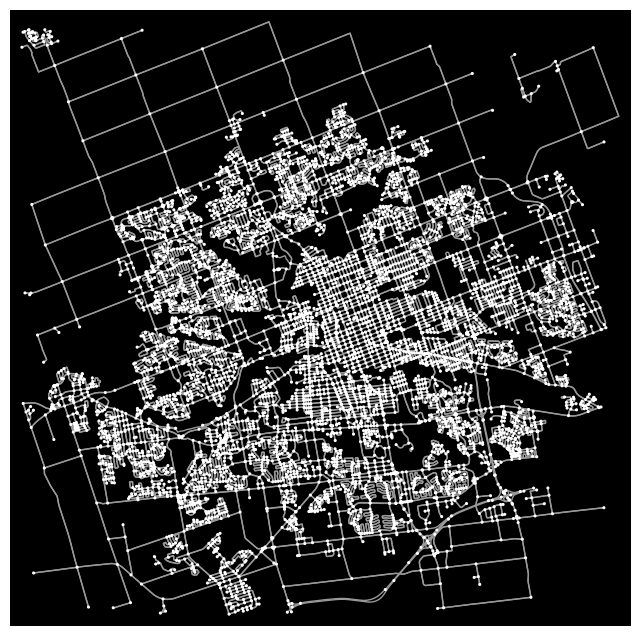

In [5]:
G=ox.graph_from_point(start, dist=10000, network_type="drive")
G=ox.add_edge_speeds(G)
G=ox.add_edge_travel_times(G)
fig, ax = ox.plot_graph(G, bgcolor="black", node_size=5, node_color="white", figsize=(16,8))

In [7]:
start_node=ox.distance.nearest_nodes(G, start[1], start[0])
dtf["node"]=dtf[["y", "x"]].apply(lambda x: ox.distance.nearest_nodes(G, x[1], x[0]), axis=1)
dtf=dtf.drop_duplicates("node", keep='first')
dtf.head()

C:\Users\ST\AppData\Local\Temp\ipykernel_18488\2197898139.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dtf["node"]=dtf[["y", "x"]].apply(lambda x: ox.distance.nearest_nodes(G, x[1], x[0]), axis=1)
C:\Users\ST\AppData\Local\Temp\ipykernel_18488\2197898139.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dtf["node"]=dtf[["y", "x"]].apply(lambda x: ox.distance.nearest_nodes(G, x[1], x[0]), axis=1)
C:\Users\ST\AppData\Local\Temp\ipykernel_18488\2197898139.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consiste

,id,City,Street Address,y,x,node
0,0,London,265 Wharncliffe Rd North,42.99,-81.26,289796441
1,1,London,"1105 Wellington Rd., Store No. 122",42.93,-81.22,324811692
2,2,London,631 Commissioners Road East,42.96,-81.23,11756886360
3,3,London,1442 Fanshawe Park Road,43.01,-81.34,252974916
4,4,London,"580 Fanshawe Park Road East, Unit 1, White Oak...",43.03,-81.26,302754873


In [8]:
def f(a , b):
    try:
        d=nx.shortest_path_length(G, source=a, target=b, method='dijkstra', weight='travel_time')
    except:
        d=np.nan
    return d

distance_matrix=np.asarray([[f(a,b)for b in dtf["node"].tolist()] for a in dtf["node"].tolist()])
distance_matrix=pd.DataFrame(distance_matrix, columns=dtf["node"].values, index=dtf["node"].values)

distance_matrix.head()

,289796441,324811692,11756886360,252974916,302754873,305539079,347554420,4727288804,2600781784,1556562903,1606842225,295523341,313507828,1609033105,312125272,260890490,311486306,3058247625,347336428,7271237232
289796441,0.0,563.0,353.1,594.3,498.5,403.4,126.5,393.7,554.8,101.7,514.3,435.3,233.3,198.9,566.9,226.3,523.0,477.2,1036.4,1046.9
324811692,590.5,0.0,210.9,1099.3,951.2,713.2,458.3,871.4,736.5,489.8,402.5,890.1,670.1,403.5,680.8,777.8,119.8,982.2,1313.0,782.8
11756886360,379.6,209.9,0.0,913.0,740.3,579.4,247.4,660.5,550.2,278.9,412.4,703.8,459.2,192.6,582.8,579.4,239.9,795.9,1203.6,915.3
252974916,592.6,1096.3,914.8,0.0,428.6,858.3,704.5,323.8,481.6,665.3,725.6,356.3,500.6,764.0,1083.2,432.8,1025.7,174.5,1308.0,980.1
302754873,498.4,952.2,742.3,429.5,0.0,480.8,572.8,107.2,892.0,513.2,865.1,764.8,348.5,569.4,705.7,394.9,981.1,312.4,930.5,1390.5


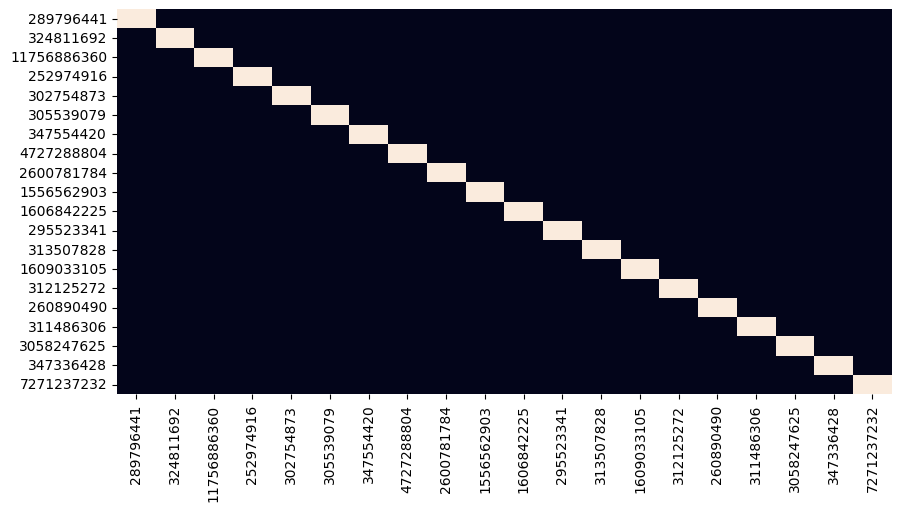

In [9]:
heatmap= distance_matrix.copy()
for col in heatmap.columns:
    heatmap[col]=heatmap[col].apply(lambda x: 
         0.3 if pd.isnull(x) else
         (0.7 if np.isinf(x) else 
          (0 if x!=0 else 1)) )
    
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(heatmap, vmin=0 , vmax=1 , cbar=False, ax=ax)
plt.show()

In [10]:
distance_matrix= distance_matrix.round()
distance_matrix=distance_matrix.astype('int')
distance_matrix

,289796441,324811692,11756886360,252974916,302754873,305539079,347554420,4727288804,2600781784,1556562903,1606842225,295523341,313507828,1609033105,312125272,260890490,311486306,3058247625,347336428,7271237232
289796441,0,563,353,594,499,403,126,394,555,102,514,435,233,199,567,226,523,477,1036,1047
324811692,590,0,211,1099,951,713,458,871,737,490,402,890,670,403,681,778,120,982,1313,783
11756886360,380,210,0,913,740,579,247,661,550,279,412,704,459,193,583,579,240,796,1204,915
252974916,593,1096,915,0,429,858,705,324,482,665,726,356,501,764,1083,433,1026,174,1308,980
302754873,498,952,742,430,0,481,573,107,892,513,865,765,349,569,706,395,981,312,930,1390
305539079,404,645,583,861,485,0,436,539,894,376,867,767,411,411,308,558,748,744,690,1363
347554420,150,456,246,715,571,435,0,467,520,92,479,518,265,92,491,349,425,598,1068,1012
4727288804,391,869,659,322,107,537,466,0,785,406,758,658,241,505,762,288,874,205,987,1283
2600781784,555,732,550,478,887,890,520,782,0,603,361,185,720,577,1002,564,661,633,1523,633
1556562903,170,488,278,668,512,376,92,407,603,0,562,538,206,124,492,336,501,550,1009,1095


In [11]:
drivers = 1 
lst_nodes= dtf["node"].tolist()
print("start:", start_node, "total locations to visit", len(lst_nodes)-1, "drivers", drivers)

start: 289796441 total locations to visit 19 drivers 1


In [12]:
manager= pywrapcp.RoutingIndexManager(len(lst_nodes), drivers, lst_nodes.index(start_node))
model=pywrapcp.RoutingModel(manager)

In [13]:
def get_distance(from_index, to_index):
    return distance_matrix.iloc[from_index, to_index]

distance=model.RegisterTransitCallback(get_distance)
model.SetArcCostEvaluatorOfAllVehicles(distance)

parameters = pywrapcp.DefaultRoutingSearchParameters()
parameters.first_solution_strategy= (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

In [14]:
solution= model.SolveWithParameters(parameters)

index=model.Start(0)
print('route for driver:')
route_idx, route_distance = [], 0

while not model.IsEnd(index):
    route_idx.append(manager.IndexToNode(index))
    previous_index=index
    index=solution.Value(model.NextVar(index))
    
    try:
        route_distance +=get_distance(previous_index, index)
    except:
        route_distance+=model.GetArcCostForVehicle(from_index=previous_index, to_index=index, vehicle=0)
        
print(route_idx)
print(f'Total distance:{round(route_distance/1000,2)}km')
print(f'Nodes visited: {len(route_idx)}')

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x0000018D86F93800>>
Traceback (most recent call last):
  File "c:\Users\ST\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\ipkernel.py", line 790, in _clean_thread_parent_frames
    active_threads = {thread.ident for thread in threading.enumerate()}
                                                 ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ST\AppData\Local\Programs\Python\Python312\Lib\threading.py", line 1543, in enumerate
    with _active_limbo_lock:
         ^^^^^^^^^^^^^^^^^^
SystemError: <built-in method __enter__ of _thread.RLock object at 0x0000018D83595000> returned a result with an exception set
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x0000018D86F93800>>
Traceback (most recent call last):
  File "c:\Users\ST\AppData\Local\Programs\Python\Python312\Lib\s

route for driver:
[0, 5, 12, 7, 17, 3, 11, 8, 10, 16, 1, 2, 13, 9, 6, 4, 15, 14, 18, 19]
Total distance:7.77km
Nodes visited: 20


In [15]:
print("Route for driver (nodes):")
lst_route=[lst_nodes[i] for i in route_idx]
print(lst_route)

Route for driver (nodes):
[289796441, 305539079, 313507828, 4727288804, 3058247625, 252974916, 295523341, 2600781784, 1606842225, 311486306, 324811692, 11756886360, 1609033105, 1556562903, 347554420, 302754873, 260890490, 312125272, 347336428, 7271237232]


In [16]:
def get_path_between_nodes(lst_route):
    lst_paths=[]
    for i in range (len(lst_route)):
        try :
            a , b = lst_nodes[i], lst_nodes[i+1]
        except:
            break
        try:
            path=nx.shortest_path(G, source=a, target=b, method ='dijkstra', weight='travel_time')
            if len(path) > 1:
                lst_paths.append(path)
        except:
            continue
    return lst_paths

lst_paths= get_path_between_nodes(lst_route)

for path in lst_paths:
    ox.plot_route_folium(G, route=path, route_map=map, color="blue", weight=1)
    
map

C:\Users\ST\AppData\Local\Temp\ipykernel_18488\1296747685.py:19: FutureWarning: The `folium` module has been deprecated and will be removed in the v2.0.0 release. You can generate and explore interactive web maps of graph nodes, edges, and/or routes automatically using GeoPandas.GeoDataFrame.explore instead, for example like: `ox.graph_to_gdfs(G, nodes=False).explore()`. See the OSMnx examples gallery for complete details and demonstrations.
  ox.plot_route_folium(G, route=path, route_map=map, color="blue", weight=1)
C:\Users\ST\AppData\Local\Temp\ipykernel_18488\1296747685.py:19: FutureWarning: The `folium` module has been deprecated and will be removed in the v2.0.0 release. You can generate and explore interactive web maps of graph nodes, edges, and/or routes automatically using GeoPandas.GeoDataFrame.explore instead, for example like: `ox.graph_to_gdfs(G, nodes=False).explore()`. See the OSMnx examples gallery for complete details and demonstrations.
  ox.plot_route_folium(G, route

In [ ]:
def df_animation_multiple_path(G, lst_paths, parallel=True):
    df=pd.DataFrame()
    for path in lst_paths :
        lst_start, lst_end = [] , []
        start_x, start_y = [] , []
        end_x, end_y = [], []
        lst_length, lst_time = [], [] 
        
        for a , b in zip (path[:-1], path[1:]):
            lst_start.append(a)
            lst_end.append(b)
            lst_length.append(round(G.edges[(a,b,0)]['length']))
            lst_time.append(round(G.edges[(a,b,0)]['travel_time']))
            start_x.append(G.nodes[a]['x'])
            start_y.append(G.nodes[a]['y'])
            end_x.append(G.nodes[b]['x'])
            end_y.append(G.nodes[b]['y'])
            
        tmp=pd.DataFrame(list(zip(lst_start, lst_end, start_x, start_y, end_x, end_y, lst_length, lst_time)), columns= ["start", "end", "start_x", "start_y", "end_x", "end_y", "length", "travel_time"])
        df=pd.concat([df,tmp], ignore_index=(not parallel))
        
    df=df.reset_index().rename(columns={"index":"id"})
    return df

In [18]:
df= pd.DataFrame()
tmp=df_animation_multiple_path(G, lst_paths, parallel=False)
df=pd.concat([df, tmp], axis=0)
first_node, last_node= lst_paths[0][0], lst_paths[-1][-1]

In [31]:
df_start= df[df["start"]== first_node]
df_end=df[df["end"]== last_node]

fig=px.scatter_mapbox(data_frame=df, lon="start_x", lat="start_y", zoom=11.5, width=1680, height=1000, animation_frame="id",mapbox_style="carto-positron")

fig.data[0].marker={"size":12}

fig.add_trace(px.scatter_mapbox(data_frame=dtf, lon="x", lat="y").data[0])
fig.data[1].marker={"size":10, "color":"black"}

fig.add_trace(px.scatter_mapbox(data_frame=df_start, lon="start_x", lat="start_y").data[0])
fig.data[2].marker={"size":15, "color":"red"}

fig.add_trace(px.scatter_mapbox(data_frame=df_end, lon="start_x", lat="start_y").data[0])
fig.data[3].marker={"size":15, "color":"green"}

fig.add_trace(px.line_mapbox(data_frame=df, lon="start_x", lat="start_y").data[0])

fig